## A/B Test - How bad is peaking?
Imagine you have a website with $20.000$ visitors per day on average where you advertise a product. You have an idea to optimize the number of people who click on the advertisement (e.g. change the color of the button on the website). In order to test if that change is helpful at all, you now direct half your visitors to the first version of the website and the other half to the other version. That's a working A/B test setup!

You can compare the results (how many people clicked the advertisement for each version of the website?) and analyse with certain rules if the two results are significantly different or if the potential change is just random and there is no improvement (which you would notice if you repeat that experiment many times).

The question is now when do we stop the experiment and draw our conclusion? Normally you set a fixed runtime based on "how good" the results should be. But since we now live in a world with live data, we may think we can stop our A/B test sooner and safe some precious time without loosing any confidence in our result.

So we peak at the result on our A/B test and may call it a day the first time we see a significant result. Instead of commiting to our fixed length of the experiment, which will guarantee us the confidence of the result, we may stop early if we see a significant result the first time around. Will this still give us the same confidence for our result, or do we run into the (higher) risk to claim a false significant result?

Since the book text A/B test doesn't make any assumptions about the evolution of the p-value over the experiment and only ever cares about the p-value at the end, you are asking a different question here, aka

'Out of all trials, how many will get at least one significant p-value over the course of the experiement?'

If the answer to that would be 'The same amount of trials as you would expect from the text book A/B test', then we would be good. But math tells us otherwise.

We can simplify and test ourself by doing an A/A test. So let's run this test and see how good we are doing by comparing the 'peaking' tactic with the text book tactic.

In [112]:
# Basic Python Libs
import numpy as np
import pandas as pd
from scipy.stats import binom, norm, ttest_ind
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from random import random
import math

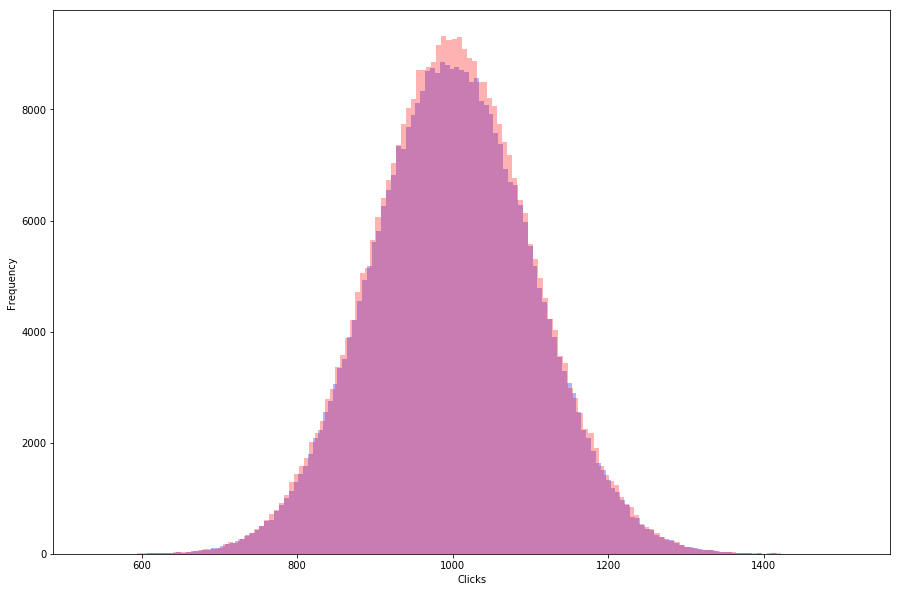

In [118]:
N_avg_visitors = 20_000 # We average 20.000 visitors per day and split them equally.
N_sigma = 500 # We know that the standard diviation for the number of visitors is +/- 500.
N_days = 365_000 # We run our experiment for 365 days and want to repeat it 1000 times.

N_visitors = np.random.normal(N_avg_visitors, N_sigma, N_days)

rate_avg = 0.10 # Say 10% of all people click on the advertisment.
rate_sigma = 0.01 # With a STD of +/- 1%.

Original_rate = np.random.normal(rate_avg, rate_sigma, N_days)
Variation_rate = np.random.normal(rate_avg, rate_sigma, N_days)

Original_clicks = N_visitors/2*Original_rate
Variation_clicks = N_visitors/2*Variation_rate

fig, ax = plt.subplots(figsize=(15, 10))
plt.hist(Original_clicks, bins=int(Original_clicks.max()/10), color='blue', alpha=0.3)
plt.hist(Variation_clicks, bins=int(Original_clicks.max()/10), color='red', alpha=0.3)
plt.xlabel('Clicks')
plt.ylabel('Frequency')
plt.show()

Now we have generated our two resultlists for both versions of the website. We can do an A/A test after each day and see if we can get a significant result (due to the statistic fluctuation).
To make things easier I made both lists 365.000 days long, as I repeated the experiment 1000 times for 365 days each. 

In [119]:
onemp_daily = []
for j in range(0,1000):
    onemp_experiment = []
    for k in range(0,365):
        t_stat, pval = ttest_ind(Original_clicks[0+j*365:j*365+k+2], Variation_clicks[0+j*365:j*365+k+2])
        onemp_experiment.append(1-pval)
    onemp_daily.append(onemp_experiment)

Now we want to plot the evolution of $1-p$ over the course of the $365$ days. We can start the test once we have 2 values. If the values of $1-p$ gets bigger than $0.95$, then we have a 'significant' result at a $95\,\%$ confidence level (CL).

In [126]:
fig = go.Figure()
for i in range(0,15):
    fig.add_trace(go.Scatter(y=onemp_daily[i], x=list(range(0,365)),
                    mode='lines',
                    name='Experiment '+ str(i)))
fig.add_trace(go.Scatter(y=[0.95]*364, x=list(range(0,365)),
                    mode='lines',
                    name='95% CL'))
fig.show()

As you can see, over the course of the whole 365 days, some lines go above the significance line. Way more than the $5\,\%$ we would expect from our A/A test for a $95\,\%$ CL. Let's see how the situation is for all 100 experiments.

In [123]:
pval_df = pd.DataFrame()
for index, p_list in enumerate(onemp_daily):
    pval_df['Experiment '+str(index)] = p_list
    
evolution_significant_list = [len(pval_df.loc[:, pval_df[:].min() <= 0.05].min()),
                                  len(pval_df.loc[:, pval_df[:].min() > 0.05].min())]

significant_notsignificant_list = [len(pval_df[:].iloc[-1][pval_df[:].iloc[-1] <= 0.05]),
                                  len(pval_df[:].iloc[-1][pval_df[:].iloc[-1] > 0.05])]


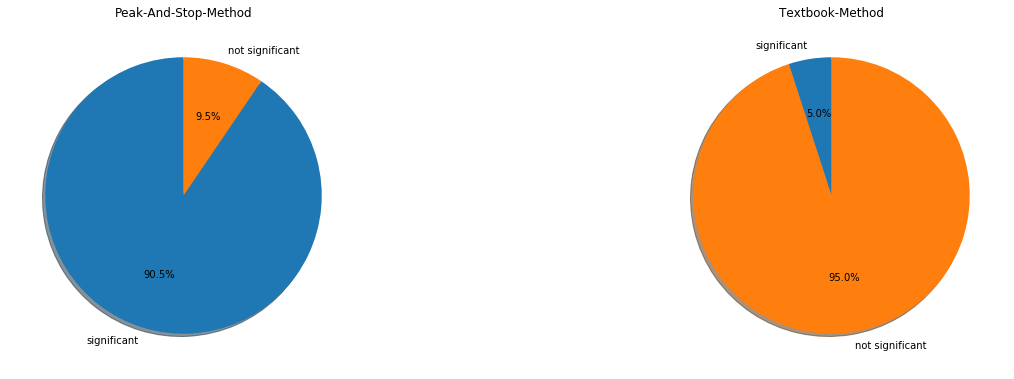

In [127]:
labels =['significant', 'not significant']

fig = plt.figure()
ax1 = fig.add_axes([0, 0, .8, 2.5], aspect=1)
ax1.pie(evolution_significant_list, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Peak-And-Stop-Method')
ax2 = fig.add_axes([1.5, 0, .8, 2.5], aspect=1)
ax2.pie(significant_notsignificant_list, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.set_title('Textbook-Method')
plt.show()

On the left, the composition of the significant and not significant results are shown for the Peak-And-Stop-Method for a $95\,\%$ CL. For this example run, a significant p-value was reached for $90.5\,\%$ of the experiment over runtime of 365 days. So the "conclusion" of this method would be that in most cases there is a significant difference between the versions, even though both versions are the same and are only different due to statistical fluctuations.

On the right, we can see the same composition, but for the Textbook-Method. Here we waited for the experiment to actually finish. As a result, our example run wields $5\,\%$ significant results at a $95\,\%$ CL. This is exactly what we expected (May vary for different runs, but it should always be close to this).

So first of, we were able to reproduce the Textbook-Method and show what it actually means.
Secondly we were able to show why peaking itself and especially acting after peaking is a bad practice and produces unusable results. 

If one wants to peak and use this information, one also needs to pay the price and run a different test to guarantee the desired confidence level.